### 导入库

In [1]:
import torch
from torch.utils import data
import torchvision
from torchvision import transforms
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

from data import LoadData
from model import VGG16
from utils import *
from loss import EdgeHoldLoss

for name in (torch, torchvision, cv2, np):
    print(name.__version__)

1.6.0+cu101
0.7.0+cu101
4.3.0
1.19.1


### 使用GPU或者CPU

In [2]:
if torch.cuda.is_available():
    device = torch.device(device='cuda')
else:
    device = torch.device(device='cpu')
device

device(type='cuda')

In [3]:
path_image = "./DUTS/DUTS-TR/DUTS-TR-Image/"
path_mask = "./DUTS/DUTS-TR/DUTS-TR-Mask/"

In [4]:
batch_size = 4 #受限于贫穷，3是极限了
learning_rate = 0.00009
target_size = 256
epochs = 1

In [5]:
data_loader = data.DataLoader(LoadData(path_image, path_mask, target_size),
                            batch_size=batch_size,
                            shuffle=True)

In [6]:
total_batch = len(data_loader)
total_batch

2639

### 导入模型

In [7]:
model = VGG16()

In [8]:
model.load_state_dict(torch.load("./model/MPFA_80.pth"), strict=False)

<All keys matched successfully>

In [9]:
model.eval()
model.to(device)
criterion = EdgeHoldLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0, momentum=0.9)

model.train()

# layers = [model.conv1_1, model.conv1_2, model.conv2_1, model.conv2_2,
#          model.conv3_1, model.conv3_2, model.conv3_3,
#          model.conv4_1, model.conv4_2, model.conv4_3,
#          model.conv5_1, model.conv5_2, model.conv5_3]

# for layer in layers:
#     for par in layer.parameters():
#         par.requires_grad = False
print()

In [10]:
for epoch in range(81, 88):
#     criterion = EdgeHoldLoss().to(device)
    criterion = torch.nn.BCELoss().to(device)
    optimizer = torch.optim.SGD(model.parameters(),
                                lr=learning_rate,
                                weight_decay=0,
                                momentum=0.9)
    print("lr:{:.10f}".format(learning_rate))
    start_time = time.time()
    learning_rate = learning_rate - learning_rate * 0.1
    total_loss = 0
    total_acc = 0
    total_pre = 0
    total_rec = 0
    total_f_score = 0
    
    for batch_n, (image, mask) in enumerate(data_loader, start=1):
        
        image = image.to(device)
        mask = mask.to(device)
        
        optimizer.zero_grad()
        predict = model(image)
        loss = criterion(predict, mask)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            total_loss += loss.item()
            acc = accuracy(predict, mask)
            total_acc += acc

            pre = precision(predict, mask)
            total_pre += pre

            rec = recall(predict, mask)
            total_rec += rec

            f_score = F_Measure(pre, rec)
            total_f_score += f_score
        
        
        if batch_n % 100 == 0:
            with torch.no_grad():
                avg_acc = total_acc / batch_n
                avg_pre = total_pre / batch_n
                avg_rec = total_rec / batch_n
                avg_f_score = total_f_score / batch_n
                print("Epoch:{} loss:{} Batch:{}/{}"
                      .format(epoch, loss.item(), batch_n, total_batch), end="")
                print(" acc:{} pre:{} recall:{} F-measure:{}"
                      .format(avg_acc, avg_pre, avg_rec, avg_f_score))
    end_time = time.time()
    print("--------------------------------------------------------------")
    print("Epoch {} time:{:.2f}s END :loss:{} acc:{} pre:{} rec:{} F-measure:{}"
          .format(epoch, 
                  end_time - start_time,
                  total_loss / total_batch, 
                  total_acc / total_batch,
                  total_pre / total_batch,
                  total_rec / total_batch,
                  total_f_score / total_batch))
    print("--------------------------------------------------------------")
    torch.save(model.state_dict(),"./model/MPFA_{}.pth".format(epoch))

lr:0.0000900000
Epoch:81 loss:0.036467358469963074 Batch:100/2639 acc:0.9235137701034546 pre:0.9152480959892273 recall:0.9007877707481384 F-measure:0.9102303385734558
Epoch:81 loss:0.09283576160669327 Batch:200/2639 acc:0.9219955205917358 pre:0.9142413139343262 recall:0.9014456868171692 F-measure:0.9094496965408325
Epoch:81 loss:0.23114386200904846 Batch:300/2639 acc:0.9217543005943298 pre:0.9176101684570312 recall:0.9051209688186646 F-measure:0.9131036400794983
Epoch:81 loss:0.09664756059646606 Batch:400/2639 acc:0.9230497479438782 pre:0.9175660014152527 recall:0.9055502414703369 F-measure:0.9130459427833557
Epoch:81 loss:0.08081579208374023 Batch:500/2639 acc:0.9210893511772156 pre:0.9159734845161438 recall:0.9036903381347656 F-measure:0.9113754034042358
Epoch:81 loss:0.04622208699584007 Batch:600/2639 acc:0.9210714101791382 pre:0.915852963924408 recall:0.9036421179771423 F-measure:0.9113150238990784
Epoch:81 loss:0.13591493666172028 Batch:700/2639 acc:0.9216884970664978 pre:0.914786

lr:0.0000729000
Epoch:83 loss:0.14579522609710693 Batch:100/2639 acc:0.9234049916267395 pre:0.9226058721542358 recall:0.9167295694351196 F-measure:0.9201821088790894
Epoch:83 loss:0.04201453551650047 Batch:200/2639 acc:0.9228807091712952 pre:0.9218529462814331 recall:0.9144179224967957 F-measure:0.9188516139984131
Epoch:83 loss:0.04212263971567154 Batch:300/2639 acc:0.9216928482055664 pre:0.9178444743156433 recall:0.9123897552490234 F-measure:0.9149932861328125
Epoch:83 loss:0.05128386616706848 Batch:400/2639 acc:0.9214193224906921 pre:0.9149405360221863 recall:0.9086560010910034 F-measure:0.9117705821990967
Epoch:83 loss:0.0635109394788742 Batch:500/2639 acc:0.9217196106910706 pre:0.9151638150215149 recall:0.9082828164100647 F-measure:0.9119436144828796
Epoch:83 loss:0.0581287145614624 Batch:600/2639 acc:0.921739399433136 pre:0.9157256484031677 recall:0.9074054956436157 F-measure:0.9121981263160706
Epoch:83 loss:0.05863706395030022 Batch:700/2639 acc:0.9219185709953308 pre:0.914693653

lr:0.0000590490
Epoch:85 loss:0.04351654648780823 Batch:100/2639 acc:0.9204403758049011 pre:0.923439085483551 recall:0.9110393524169922 F-measure:0.9195364117622375
Epoch:85 loss:0.05416133999824524 Batch:200/2639 acc:0.9205052256584167 pre:0.9225844144821167 recall:0.9118167161941528 F-measure:0.918904721736908
Epoch:85 loss:0.055635880678892136 Batch:300/2639 acc:0.9218958616256714 pre:0.9221830368041992 recall:0.9102660417556763 F-measure:0.9181732535362244
Epoch:85 loss:0.05279727280139923 Batch:400/2639 acc:0.9231175184249878 pre:0.9218292832374573 recall:0.9107863306999207 F-measure:0.9180316925048828
Epoch:85 loss:0.04701820760965347 Batch:500/2639 acc:0.9227683544158936 pre:0.9206055402755737 recall:0.910603404045105 F-measure:0.9170041084289551
Epoch:85 loss:0.06872478872537613 Batch:600/2639 acc:0.9220139980316162 pre:0.9203693866729736 recall:0.9113376140594482 F-measure:0.9169806241989136
Epoch:85 loss:0.05879770964384079 Batch:700/2639 acc:0.9222546219825745 pre:0.92041432

lr:0.0000478297
Epoch:87 loss:0.05601132661104202 Batch:100/2639 acc:0.9210573434829712 pre:0.9184723496437073 recall:0.9096434712409973 F-measure:0.9144663214683533
Epoch:87 loss:0.11905980110168457 Batch:200/2639 acc:0.9222581386566162 pre:0.9176863431930542 recall:0.9087862372398376 F-measure:0.9139211773872375
Epoch:87 loss:0.07372504472732544 Batch:300/2639 acc:0.9216095209121704 pre:0.915881872177124 recall:0.9075587391853333 F-measure:0.9121696352958679
Epoch:87 loss:0.0433991402387619 Batch:400/2639 acc:0.9212290644645691 pre:0.9168246984481812 recall:0.9057736992835999 F-measure:0.9125726222991943
Epoch:87 loss:0.04377879202365875 Batch:500/2639 acc:0.9219992160797119 pre:0.9161298274993896 recall:0.907431960105896 F-measure:0.912297785282135
Epoch:87 loss:0.06416855752468109 Batch:600/2639 acc:0.9216993451118469 pre:0.9147287011146545 recall:0.906255304813385 F-measure:0.9109060764312744
Epoch:87 loss:0.05303651839494705 Batch:700/2639 acc:0.9213262796401978 pre:0.91530436277

In [11]:
# torch.save(model.state_dict(),"./model/MPFA_47.pth")

In [12]:
def pad_resize_image(inp_img, out_img=None, target_size=None):
    h, w, c = inp_img.shape
    size = max(h, w)

    padding_h = (size - h) // 2
    padding_w = (size - w) // 2

    if out_img is None:
        # For inference
        temp_x = cv2.copyMakeBorder(inp_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        if target_size is not None:
            temp_x = cv2.resize(temp_x, (target_size, target_size), interpolation=cv2.INTER_AREA)
        return temp_x
    else:
        # For training and testing
        temp_x = cv2.copyMakeBorder(inp_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        temp_y = cv2.copyMakeBorder(out_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        # print(inp_img.shape, temp_x.shape, out_img.shape, temp_y.shape)

        if target_size is not None:
            temp_x = cv2.resize(temp_x, (target_size, target_size), interpolation=cv2.INTER_AREA)
            temp_y = cv2.resize(temp_y, (target_size, target_size), interpolation=cv2.INTER_AREA)
        return temp_x, temp_y


In [13]:
def getInput(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype('float32')
    
    img = pad_resize_image(img, target_size=256)
    img /= 255.
    img = np.transpose(img, axes=(2, 0, 1))
    img = torch.from_numpy(img).float()
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]) 
    
    img = normalize(img)
    return img

In [14]:
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

In [15]:
msk.shape

torch.Size([256, 256, 1])

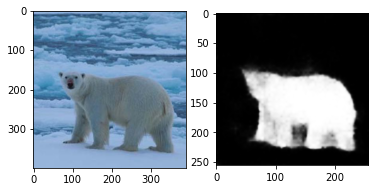

In [16]:
img = getInput("./image/1.jpg")
img = img.reshape(1, 3, 256, 256)
img = img.to(device)
predict = model(img)
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./image/1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(msk, cmap='gray')
plt.show()

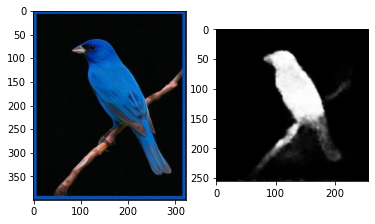

In [17]:
img = getInput("./image/2.jpg")
img = img.reshape(1, 3, 256, 256)
img = img.to(device)
predict = model(img)
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./image/2.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(msk, cmap='gray')
plt.show()

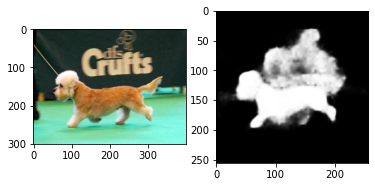

In [18]:
img = getInput("./image/3.jpg")
img = img.reshape(1, 3, 256, 256)
img = img.to(device)
predict = model(img)
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./image/3.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(msk, cmap='gray')
plt.show()